In [81]:
from torch import nn, optim
import os
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import default_rng
import torch
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [23]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [24]:
df15 = load_data(2015).set_index("C28992R100")
df16 = load_data(2016).set_index("C28992R100")
df17 = load_data(2017).set_index("C28992R100")
df18 = load_data(2018).set_index("C28992R100")
df19 = load_data(2019).set_index("C28992R100")


In [25]:
# Get data that is available in all years
overlapping1517 = df17.index[df17.index.isin(df16.index[df16.index.isin(df15.index)])]
overlapping1518 = df18.index[df18.index.isin(overlapping1517)]
overlapping1519 = df19.index[df19.index.isin(overlapping1518)]

# Fill X and Y
X = np.zeros((len(overlapping1519), 5, 40))
Y = np.zeros((len(overlapping1519), 5))
Y_1 = np.zeros((len(overlapping1519), 5))
ss = StandardScaler()

for i, df in enumerate([df15, df16, df17, df18, df19]):
    X[:,i] = df[df.columns[:-3]].loc[overlapping1519]
    Y[:,i] = df.loc[overlapping1519]["y"]
    Y_1[:,i] = df.loc[overlapping1519]["y-1"]


In [26]:
# Create neighbor lists for all years

df15 = df15.loc[overlapping1519]
df16 = df16.loc[overlapping1519]
df17 = df17.loc[overlapping1519]
df18 = df18.loc[overlapping1519]
df19 = df19.loc[overlapping1519]


w15 = libpysal.weights.DistanceBand.from_dataframe(df15.reset_index(), threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16.reset_index(), threshold=150, binary = True, silence_warnings = True)
w17 = libpysal.weights.DistanceBand.from_dataframe(df17.reset_index(), threshold=150, binary = True, silence_warnings = True)
w18 = libpysal.weights.DistanceBand.from_dataframe(df18.reset_index(), threshold=150, binary = True, silence_warnings = True)
w19 = libpysal.weights.DistanceBand.from_dataframe(df19.reset_index(), threshold=150, binary = True, silence_warnings = True)

In [27]:
# create Y(t-1) for all years

def get_y_1(y1, w):
    neighbors = [w.neighbors[x] for x in w.neighbors]
    y1 = np.array([y1[x].sum() for x in neighbors])
    y1[np.where(y1 == 0)[0]] = 0.5

    return y1

Y1_15 = get_y_1(Y_1[:,0], w15)
Y1_16 = get_y_1(Y_1[:,1], w16)
Y1_17 = get_y_1(Y_1[:,2], w17)
Y1_18 = get_y_1(Y_1[:,3], w18)
Y1_19 = get_y_1(Y_1[:,4], w19)



In [28]:
rng = default_rng()
def get_batch(X, Y, Y1, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs], Y1[idxs]



In [29]:
# X train is the first three years
X_train = X[:,:3]

#fill X_train Y(t-1) with actual values for resampling
X_train[:,0,39] = Y1_15
X_train[:,1,39] = Y1_16
X_train[:,2,39] = Y1_17

X_train = X_train.reshape(-1, 40*3)


Y_train = Y[:,2]


In [30]:
# oversample X_train using SMOTE

smote = SMOTE()
X_train_resample,Y_train_resample = smote.fit_resample(X_train,Y_train)
X_train = X_train.reshape(-1,3,40)
X_train_resample = X_train_resample.reshape(-1,3,40)

# transform Y(t-1) to proper values

Y1_17r = X_train_resample[:,2,-1]
Y1_17r[Y1_17r>0.5] =  np.ceil(Y1_17r[Y1_17r > 0.5])

X_train_resample = np.delete(X_train_resample, -1, 2)
X_train = np.delete(X_train, -1, 2)

X_train = X_train.reshape(-1, 39)
X_train_resample = X_train_resample.reshape(-1, 39)

# Fit and transform the standard scaler
X_train = ss.fit_transform(X_train)
X_train_resample = ss.transform(X_train_resample)

X_train_resample = X_train_resample.reshape(-1,3, 39)

Y1_17r = torch.tensor(Y1_17r).float().to(device).to(device)
Y1_18 = torch.tensor(Y1_18).float().to(device).to(device)

In [31]:
# create X_val and X_test
X_val = X[:,:4]
Y_val = Y[:,3]
X_val = np.delete(X_val, -1, 2)

X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(-1, 4, 39)



X_test = X[:,:5]
Y_test = Y[:,4]
X_test = np.delete(X_test, -1, 2)
X_test = X_test.reshape(-1, 39)

X_test = ss.transform(X_test)
X_test = X_test.reshape(-1, 5, 39)

X_val = torch.tensor(X_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)




In [33]:
Y_val = torch.tensor(Y_val).float().to(device)
X_train_resample = torch.tensor(X_train_resample).float().to(device)
Y_train_resample = torch.tensor(Y_train_resample).float().to(device)


In [116]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.GRU = nn.GRU(input_size = 39, dropout = 0.2,num_layers = 2,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        return X


In [117]:
class RNN1(nn.Module):
    def __init__(self):
        super(RNN1, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [118]:
class RNN2(nn.Module):
    def __init__(self):
        super(RNN2, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [119]:
class RNN3(nn.Module):
    def __init__(self):
        super(RNN3, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 2,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [120]:
class RNN4(nn.Module):
    def __init__(self):
        super(RNN4, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [121]:
class RNN5(nn.Module):
    def __init__(self):
        super(RNN5, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,150),
            nn.ReLU(),
            nn.Linear(150,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [144]:
model = RNN().to(device)
model1 = RNN1().to(device)
model2 = RNN2().to(device)
model3 = RNN3().to(device)
model4 = RNN4().to(device)
model5 = RNN5().to(device)

models = [model4]

In [145]:
def train(models, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    
    for i, model in enumerate(models):
        for lr in [0.00000051]:
            optimizer = optim.Adam(model.parameters(), lr=lr) 
            SigBCEloss = nn.BCEWithLogitsLoss()
            ROC_history = []

            for epoch in range(num_epochs):
                epoch_loss = []
#                 print("epoch: {} of {}".format(epoch, num_epochs))
                for batch in range(batch_per_e):

                    x, y, y1 = get_batch(X_train, Y_train, Y1_train, 6)

                    model.train()

                    optimizer.zero_grad()
                    out = model(x, y1).squeeze()


                    loss = SigBCEloss(out, y)
                    loss.backward()
                    optimizer.step()


                    epoch_loss.append(loss.detach().numpy())

                model.eval()

                out = model(X_val, Y1_val)
                ROC = roc_auc_score(Y_val, model.final(out).detach().numpy())
                out = out.squeeze().detach().numpy()

                preds = np.zeros(len(out))
                pos = out.argsort()[-((Y_val == 1).sum()):]
                preds[pos] = 1
                
                f1 = f1_score(Y_val, preds)

                ROC_history.append(ROC)

                if ROC > best_auc:
                    print("model: {}, ROC:{}, f1: {}, lr: {}, epoch = {}".format(i, ROC, f1, lr, epoch))
                    best_auc = ROC
                    best_f1 = f1
                    best_model = deepcopy(model.state_dict())
                    best_epoch = epoch
                    best_lr = lr

                train_loss = []
                          
            print(np.max(ROC_history), np.argmax(ROC_history), lr)
            plt.plot(ROC_history, alpha = 0.5)
            plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
            linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
            linear_model_fn=np.poly1d(linear_model)
            x_s=np.arange(0,n_epochs)
            plt.plot(linear_model_fn(x_s))  
            plt.show()
                          
    result = np.argmax(ROC_history)
    return best_auc, best_f1, best_model, best_epoch

model: 0, ROC:0.6225050565044304, f1: 0.28205128205128205, lr: 5.1e-07, epoch = 0
model: 0, ROC:0.6229370888803277, f1: 0.2833333333333333, lr: 5.1e-07, epoch = 1
model: 0, ROC:0.6233990411369376, f1: 0.28397435897435896, lr: 5.1e-07, epoch = 2
model: 0, ROC:0.6237205349371459, f1: 0.2846153846153846, lr: 5.1e-07, epoch = 3
model: 0, ROC:0.6240910777221295, f1: 0.28525641025641024, lr: 5.1e-07, epoch = 4
model: 0, ROC:0.6245241356677083, f1: 0.28717948717948716, lr: 5.1e-07, epoch = 5
model: 0, ROC:0.6249509064252387, f1: 0.2878205128205128, lr: 5.1e-07, epoch = 6
model: 0, ROC:0.6252536724312601, f1: 0.2878205128205128, lr: 5.1e-07, epoch = 7
model: 0, ROC:0.625596881554728, f1: 0.28910256410256413, lr: 5.1e-07, epoch = 8
model: 0, ROC:0.6260188811837393, f1: 0.2878205128205128, lr: 5.1e-07, epoch = 9
model: 0, ROC:0.6263606188376638, f1: 0.2878205128205128, lr: 5.1e-07, epoch = 10
model: 0, ROC:0.626742755019049, f1: 0.28974358974358977, lr: 5.1e-07, epoch = 11
model: 0, ROC:0.626961

model: 0, ROC:0.6470306190516959, f1: 0.3038461538461538, lr: 5.1e-07, epoch = 101
model: 0, ROC:0.6472066603170527, f1: 0.3038461538461538, lr: 5.1e-07, epoch = 102
model: 0, ROC:0.6473303083486723, f1: 0.3032051282051282, lr: 5.1e-07, epoch = 103
model: 0, ROC:0.6474741556440221, f1: 0.3038461538461538, lr: 5.1e-07, epoch = 104
model: 0, ROC:0.6476351700840433, f1: 0.3038461538461538, lr: 5.1e-07, epoch = 105
model: 0, ROC:0.6478032297418775, f1: 0.3038461538461538, lr: 5.1e-07, epoch = 106
model: 0, ROC:0.6479774874077879, f1: 0.30448717948717946, lr: 5.1e-07, epoch = 107
model: 0, ROC:0.648118035044162, f1: 0.30448717948717946, lr: 5.1e-07, epoch = 108
model: 0, ROC:0.6483091477248405, f1: 0.30448717948717946, lr: 5.1e-07, epoch = 109
model: 0, ROC:0.648500215815533, f1: 0.30448717948717946, lr: 5.1e-07, epoch = 110
model: 0, ROC:0.6486639502447098, f1: 0.30448717948717946, lr: 5.1e-07, epoch = 111
model: 0, ROC:0.6488170276671946, f1: 0.30512820512820515, lr: 5.1e-07, epoch = 112


model: 0, ROC:0.659618550504402, f1: 0.3121794871794872, lr: 5.1e-07, epoch = 200
model: 0, ROC:0.6597124124252671, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 201
model: 0, ROC:0.6597894193313643, f1: 0.3121794871794872, lr: 5.1e-07, epoch = 202
model: 0, ROC:0.6598303529386584, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 203
model: 0, ROC:0.6599216286403264, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 204
model: 0, ROC:0.6600229370888804, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 205
model: 0, ROC:0.6601179137593995, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 206
model: 0, ROC:0.6602134700997389, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 207
model: 0, ROC:0.6602789281994207, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 208
model: 0, ROC:0.6603906707047358, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 209
model: 0, ROC:0.6604577786339055, f1: 0.31153846153846154, lr: 5.1e-07, epoch = 210
model: 0, ROC:0.6605339829202518, f1: 0.31153846153846154, lr: 5.1e-07, epoch =

model: 0, ROC:0.667418186293395, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 299
model: 0, ROC:0.6674791853944608, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 300
model: 0, ROC:0.6675520454318451, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 301
model: 0, ROC:0.6676246379293124, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 302
model: 0, ROC:0.6676751583836309, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 303
model: 0, ROC:0.6677222899990012, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 304
model: 0, ROC:0.6677804799309389, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 305
model: 0, ROC:0.6678417019819357, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 306
model: 0, ROC:0.6679067587717421, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 307
model: 0, ROC:0.667955183496711, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 308
model: 0, ROC:0.6679933971148495, f1: 0.31474358974358974, lr: 5.1e-07, epoch = 309
model: 0, ROC:0.6680415542999014, f1: 0.31474358974358974, lr: 5.1e-07, epoch 

model: 0, ROC:0.6730706358888746, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 398
model: 0, ROC:0.6730767447169784, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 399
model: 0, ROC:0.6731153596449924, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 400
model: 0, ROC:0.6731581660317053, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 401
model: 0, ROC:0.6731629371602244, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 402
model: 0, ROC:0.6731870603427365, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 403
model: 0, ROC:0.673247925673844, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 404
model: 0, ROC:0.6732774442446812, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 405
model: 0, ROC:0.6733132054135811, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 406
model: 0, ROC:0.673383702181699, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 407
model: 0, ROC:0.6734290501976228, f1: 0.32051282051282054, lr: 5.1e-07, epoch = 408
model: 0, ROC:0.6735025344948133, f1: 0.32051282051282054, lr: 5.1e-07, epoch 

model: 0, ROC:0.6779113693763109, f1: 0.32564102564102565, lr: 5.1e-07, epoch = 497
model: 0, ROC:0.677933218469529, f1: 0.32564102564102565, lr: 5.1e-07, epoch = 498
model: 0, ROC:0.6779742858467818, f1: 0.3262820512820513, lr: 5.1e-07, epoch = 499
model: 0, ROC:0.6780289977597991, f1: 0.3262820512820513, lr: 5.1e-07, epoch = 500
model: 0, ROC:0.6780825503331763, f1: 0.3262820512820513, lr: 5.1e-07, epoch = 501
model: 0, ROC:0.6781060492558824, f1: 0.3262820512820513, lr: 5.1e-07, epoch = 502
model: 0, ROC:0.6781604490389967, f1: 0.3262820512820513, lr: 5.1e-07, epoch = 503
model: 0, ROC:0.6782181484810867, f1: 0.32564102564102565, lr: 5.1e-07, epoch = 504
model: 0, ROC:0.6782301431873635, f1: 0.32564102564102565, lr: 5.1e-07, epoch = 505
model: 0, ROC:0.6782916773682633, f1: 0.32564102564102565, lr: 5.1e-07, epoch = 506
model: 0, ROC:0.6783313178659589, f1: 0.32564102564102565, lr: 5.1e-07, epoch = 507
model: 0, ROC:0.6783336811352254, f1: 0.32564102564102565, lr: 5.1e-07, epoch = 50

model: 0, ROC:0.6819397624958977, f1: 0.32756410256410257, lr: 5.1e-07, epoch = 598
model: 0, ROC:0.6819920665496625, f1: 0.32756410256410257, lr: 5.1e-07, epoch = 599
model: 0, ROC:0.682041160124424, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 600
model: 0, ROC:0.6820799980023686, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 601
model: 0, ROC:0.6821287348572407, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 602
model: 0, ROC:0.6821356908950815, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 603
model: 0, ROC:0.6821986073655523, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 604
model: 0, ROC:0.6822394517928743, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 605
model: 0, ROC:0.6822773978710958, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 606
model: 0, ROC:0.6823311733944039, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 607
model: 0, ROC:0.6823660427635803, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 608
model: 0, ROC:0.6824007783627984, f1: 0.3282051282051282, lr: 5.1e-07, epoch = 609
mod

model: 0, ROC:0.6857427978254356, f1: 0.3314102564102564, lr: 5.1e-07, epoch = 701
model: 0, ROC:0.6857668764179616, f1: 0.3314102564102564, lr: 5.1e-07, epoch = 702
model: 0, ROC:0.6857971976085498, f1: 0.33205128205128204, lr: 5.1e-07, epoch = 703
model: 0, ROC:0.6858249325799409, f1: 0.33205128205128204, lr: 5.1e-07, epoch = 704
model: 0, ROC:0.6858535593510551, f1: 0.33205128205128204, lr: 5.1e-07, epoch = 705
model: 0, ROC:0.6858834346417818, f1: 0.33205128205128204, lr: 5.1e-07, epoch = 706
model: 0, ROC:0.685903633905512, f1: 0.33205128205128204, lr: 5.1e-07, epoch = 707
model: 0, ROC:0.6859309675670276, f1: 0.33205128205128204, lr: 5.1e-07, epoch = 708
model: 0, ROC:0.6859727483840589, f1: 0.33205128205128204, lr: 5.1e-07, epoch = 709
model: 0, ROC:0.6860132360914916, f1: 0.3326923076923077, lr: 5.1e-07, epoch = 710
model: 0, ROC:0.6860568450979554, f1: 0.3326923076923077, lr: 5.1e-07, epoch = 711
model: 0, ROC:0.6861138756902531, f1: 0.3326923076923077, lr: 5.1e-07, epoch = 71

model: 0, ROC:0.6892567116847167, f1: 0.3371794871794872, lr: 5.1e-07, epoch = 802
model: 0, ROC:0.6892932754733672, f1: 0.3371794871794872, lr: 5.1e-07, epoch = 803
model: 0, ROC:0.6893428595379765, f1: 0.3371794871794872, lr: 5.1e-07, epoch = 804
model: 0, ROC:0.6893778180871253, f1: 0.3371794871794872, lr: 5.1e-07, epoch = 805
model: 0, ROC:0.689405731418461, f1: 0.3371794871794872, lr: 5.1e-07, epoch = 806
model: 0, ROC:0.6894390401381221, f1: 0.3371794871794872, lr: 5.1e-07, epoch = 807
model: 0, ROC:0.6894772537562603, f1: 0.3371794871794872, lr: 5.1e-07, epoch = 808
model: 0, ROC:0.6895353099182397, f1: 0.3371794871794872, lr: 5.1e-07, epoch = 809
model: 0, ROC:0.6895680389680807, f1: 0.33653846153846156, lr: 5.1e-07, epoch = 810
model: 0, ROC:0.6896063863561777, f1: 0.33653846153846156, lr: 5.1e-07, epoch = 811
model: 0, ROC:0.6896475429134027, f1: 0.33653846153846156, lr: 5.1e-07, epoch = 812
model: 0, ROC:0.689663862848337, f1: 0.33653846153846156, lr: 5.1e-07, epoch = 813
mo

model: 0, ROC:0.6925700597862534, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 903
model: 0, ROC:0.6925902144599974, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 904
model: 0, ROC:0.6926003363868557, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 905
model: 0, ROC:0.6926189750010701, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 906
model: 0, ROC:0.6926492516016722, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 907
model: 0, ROC:0.6926823819613885, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 908
model: 0, ROC:0.6926978546865858, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 909
model: 0, ROC:0.6927226467188904, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 910
model: 0, ROC:0.6927379856741291, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 911
model: 0, ROC:0.6927773140419217, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 912
model: 0, ROC:0.692816062739894, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 913
model: 0, ROC:0.6928551235677696, f1: 0.33974358974358976, lr: 5.1e-07, epoch

model: 0, ROC:0.6955147824722114, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1008
model: 0, ROC:0.695520534580426, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1009
model: 0, ROC:0.6955678891457273, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1010
model: 0, ROC:0.6955872857897065, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1012
model: 0, ROC:0.6955973631265785, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1013
model: 0, ROC:0.695664961545596, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1014
model: 0, ROC:0.6956967987957136, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1015
model: 0, ROC:0.6956999200947448, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1016
model: 0, ROC:0.6957257822867171, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1017
model: 0, ROC:0.6957476759699214, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1018
model: 0, ROC:0.6958029229627728, f1: 0.33974358974358976, lr: 5.1e-07, epoch = 1019
model: 0, ROC:0.695837747741963, f1: 0.3403846153846154, lr: 5.1e-0

model: 0, ROC:0.6981802380748541, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1110
model: 0, ROC:0.6982272805102521, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1111
model: 0, ROC:0.698238740136695, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1112
model: 0, ROC:0.6982601879200376, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1113
model: 0, ROC:0.6982918468102108, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1114
model: 0, ROC:0.6983112880441762, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1115
model: 0, ROC:0.6983399594052766, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1116
model: 0, ROC:0.6983797336729307, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1117
model: 0, ROC:0.6984137558323702, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1118
model: 0, ROC:0.6984396626143288, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1119
model: 0, ROC:0.6984565176290969, f1: 0.34102564102564104, lr: 5.1e-07, epoch = 1120
model: 0, ROC:0.6984677988955952, f1: 0.34102564102564104, lr: 5.1

model: 0, ROC:0.7003505664711841, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1209
model: 0, ROC:0.7003772312829074, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1210
model: 0, ROC:0.700404297404506, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1211
model: 0, ROC:0.7004075970634819, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1212
model: 0, ROC:0.7004109859024299, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1213
model: 0, ROC:0.7004284205870182, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1214
model: 0, ROC:0.7004574486680079, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1216
model: 0, ROC:0.7004734118830529, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1217
model: 0, ROC:0.7004846039695789, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1218
model: 0, ROC:0.7005021278341395, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1219
model: 0, ROC:0.7005289710058074, f1: 0.3423076923076923, lr: 5.1e-07, epoch = 1220
model: 0, ROC:0.7005477879799666, f1: 0.3423076923076923, lr: 5.1e-07, epoch 

model: 0, ROC:0.702189056190517, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1314
model: 0, ROC:0.7022242822795828, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1315
model: 0, ROC:0.7022443923633406, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1316
model: 0, ROC:0.7022567437895068, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1317
model: 0, ROC:0.7022771660031676, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1318
model: 0, ROC:0.7023011554157212, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1319
model: 0, ROC:0.702316984860808, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1320
model: 0, ROC:0.7023361139648703, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1321
model: 0, ROC:0.7023495801406903, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1322
model: 0, ROC:0.7023630017265243, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1323
model: 0, ROC:0.7023792324814863, f1: 0.3435897435897436, lr: 5.1e-07, epoch = 1324
model: 0, ROC:0.7024051838534309, f1: 0.3435897435897436, lr: 5.1e-07, epoch =

model: 0, ROC:0.7037239772840774, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1417
model: 0, ROC:0.7037513555355793, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1418
model: 0, ROC:0.7037659810510395, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1419
model: 0, ROC:0.7037669620307349, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1420
model: 0, ROC:0.703778733787081, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1421
model: 0, ROC:0.7037891678438423, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1422
model: 0, ROC:0.7037984871509495, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1423
model: 0, ROC:0.7038068254783614, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1424
model: 0, ROC:0.7038121316867143, f1: 0.3474358974358974, lr: 5.1e-07, epoch = 1425
model: 0, ROC:0.7038319742305552, f1: 0.34807692307692306, lr: 5.1e-07, epoch = 1426
model: 0, ROC:0.7038411151777177, f1: 0.34807692307692306, lr: 5.1e-07, epoch = 1427
model: 0, ROC:0.7038462430261262, f1: 0.34807692307692306, lr: 5.1e-07, epo

model: 0, ROC:0.7050037544768346, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1520
model: 0, ROC:0.7050152141032775, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1521
model: 0, ROC:0.7050262278298589, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1522
model: 0, ROC:0.7050311327283363, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1523
model: 0, ROC:0.7050425923547794, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1524
model: 0, ROC:0.7050510644521496, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1525
model: 0, ROC:0.7050651102977897, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1526
model: 0, ROC:0.7050708178160182, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1527
model: 0, ROC:0.7050737607551046, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1528
model: 0, ROC:0.7050866472611046, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1530
model: 0, ROC:0.7050897685601359, f1: 0.3487179487179487, lr: 5.1e-07, epoch = 1531
model: 0, ROC:0.7051112609334647, f1: 0.3487179487179487, lr: 5.1e-07, epoch

model: 0, ROC:0.7059961046188091, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1645
model: 0, ROC:0.7059982003481586, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1646
model: 0, ROC:0.706011755703951, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1647
model: 0, ROC:0.7060263366294252, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1648
model: 0, ROC:0.7060445739337643, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1649
model: 0, ROC:0.7060535365209822, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1651
model: 0, ROC:0.7060615181285048, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1653
model: 0, ROC:0.7060768124937574, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1654
model: 0, ROC:0.7060849724612246, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1656
model: 0, ROC:0.7060926419388439, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1657
model: 0, ROC:0.7060960753677782, f1: 0.35128205128205126, lr: 5.1e-07, epoch = 1658
model: 0, ROC:0.70609768060728, f1: 0.35128205128205126, lr: 5.1e-

model: 0, ROC:0.7068753745558838, f1: 0.3525641025641026, lr: 5.1e-07, epoch = 1767
model: 0, ROC:0.706885228942825, f1: 0.3525641025641026, lr: 5.1e-07, epoch = 1768
model: 0, ROC:0.706902619037427, f1: 0.35192307692307695, lr: 5.1e-07, epoch = 1769
model: 0, ROC:0.7069072563959877, f1: 0.35192307692307695, lr: 5.1e-07, epoch = 1770
model: 0, ROC:0.7069118491645621, f1: 0.35192307692307695, lr: 5.1e-07, epoch = 1771
model: 0, ROC:0.7069236209209081, f1: 0.35192307692307695, lr: 5.1e-07, epoch = 1773
model: 0, ROC:0.7069266084499807, f1: 0.3525641025641026, lr: 5.1e-07, epoch = 1775
model: 0, ROC:0.706928659589344, f1: 0.35192307692307695, lr: 5.1e-07, epoch = 1776
model: 0, ROC:0.7069365520168943, f1: 0.3525641025641026, lr: 5.1e-07, epoch = 1777
model: 0, ROC:0.7069409664255241, f1: 0.3525641025641026, lr: 5.1e-07, epoch = 1778
model: 0, ROC:0.7069563499707489, f1: 0.3525641025641026, lr: 5.1e-07, epoch = 1779
model: 0, ROC:0.7069604076594894, f1: 0.3525641025641026, lr: 5.1e-07, epo

model: 0, ROC:0.7076348757901345, f1: 0.3544871794871795, lr: 5.1e-07, epoch = 1964
model: 0, ROC:0.7076458003367435, f1: 0.3551282051282051, lr: 5.1e-07, epoch = 1965
model: 0, ROC:0.707655208823823, f1: 0.3551282051282051, lr: 5.1e-07, epoch = 1969
model: 0, ROC:0.7076606042121485, f1: 0.3544871794871795, lr: 5.1e-07, epoch = 1970
model: 0, ROC:0.7076612730619409, f1: 0.3544871794871795, lr: 5.1e-07, epoch = 1971
model: 0, ROC:0.7076644835409442, f1: 0.3551282051282051, lr: 5.1e-07, epoch = 1972
model: 0, ROC:0.7076716625287159, f1: 0.3551282051282051, lr: 5.1e-07, epoch = 1973
model: 0, ROC:0.7076785739765706, f1: 0.3551282051282051, lr: 5.1e-07, epoch = 1974
model: 0, ROC:0.7076823641253942, f1: 0.3551282051282051, lr: 5.1e-07, epoch = 1976
model: 0, ROC:0.7076881608235949, f1: 0.3551282051282051, lr: 5.1e-07, epoch = 1977
model: 0, ROC:0.7076882500035672, f1: 0.3551282051282051, lr: 5.1e-07, epoch = 1978
model: 0, ROC:0.7077011810995533, f1: 0.3557692307692308, lr: 5.1e-07, epoch 

model: 0, ROC:0.7082720666923505, f1: 0.3557692307692308, lr: 5.1e-07, epoch = 2139
model: 0, ROC:0.7082889662971049, f1: 0.3557692307692308, lr: 5.1e-07, epoch = 2140
model: 0, ROC:0.7082899472768003, f1: 0.3557692307692308, lr: 5.1e-07, epoch = 2160
model: 0, ROC:0.708294584635361, f1: 0.3557692307692308, lr: 5.1e-07, epoch = 2164
model: 0, ROC:0.7083035918125651, f1: 0.3557692307692308, lr: 5.1e-07, epoch = 2165
model: 0, ROC:0.7083049741021361, f1: 0.3557692307692308, lr: 5.1e-07, epoch = 2166
model: 0, ROC:0.7083073373714024, f1: 0.3564102564102564, lr: 5.1e-07, epoch = 2167
model: 0, ROC:0.7083188861778177, f1: 0.3564102564102564, lr: 5.1e-07, epoch = 2168
model: 0, ROC:0.7083244599260876, f1: 0.35705128205128206, lr: 5.1e-07, epoch = 2178
model: 0, ROC:0.7083327536635133, f1: 0.3564102564102564, lr: 5.1e-07, epoch = 2179
model: 0, ROC:0.7083382828217971, f1: 0.3564102564102564, lr: 5.1e-07, epoch = 2180
model: 0, ROC:0.7083424296905098, f1: 0.3564102564102564, lr: 5.1e-07, epoch

model: 0, ROC:0.7089726199648988, f1: 0.358974358974359, lr: 5.1e-07, epoch = 2407
model: 0, ROC:0.7089796651827118, f1: 0.358974358974359, lr: 5.1e-07, epoch = 2408
model: 0, ROC:0.7089809582923106, f1: 0.358974358974359, lr: 5.1e-07, epoch = 2409
model: 0, ROC:0.7089990618266913, f1: 0.358974358974359, lr: 5.1e-07, epoch = 2410
model: 0, ROC:0.7090021831257223, f1: 0.358974358974359, lr: 5.1e-07, epoch = 2414
model: 0, ROC:0.7090047693449195, f1: 0.3596153846153846, lr: 5.1e-07, epoch = 2420
model: 0, ROC:0.7090135981621792, f1: 0.3596153846153846, lr: 5.1e-07, epoch = 2421
model: 0, ROC:0.7090164073313071, f1: 0.3596153846153846, lr: 5.1e-07, epoch = 2428
model: 0, ROC:0.7090260833583037, f1: 0.3596153846153846, lr: 5.1e-07, epoch = 2436
model: 0, ROC:0.7090379442946221, f1: 0.3596153846153846, lr: 5.1e-07, epoch = 2437
model: 0, ROC:0.7090461042620892, f1: 0.3596153846153846, lr: 5.1e-07, epoch = 2463
model: 0, ROC:0.7090481554014526, f1: 0.3596153846153846, lr: 5.1e-07, epoch = 24

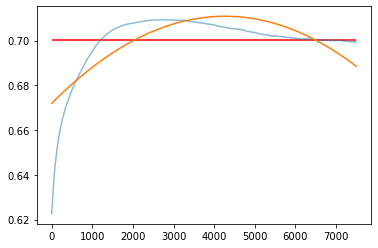

In [146]:
n_epochs = 7500
hists = train(models, X_train_resample, Y_train_resample, Y1_17r, X_val, Y_val, Y1_18, n_epochs, 0.0000051)

In [133]:
hists

(0.7066298620920908,
 0.3487179487179487,
 OrderedDict([('GRU.weight_ih_l0',
               tensor([[ 0.1104, -0.0999, -0.1255,  ...,  0.1014,  0.0918,  0.1336],
                       [-0.1312, -0.0523, -0.1097,  ...,  0.0872, -0.0632, -0.1020],
                       [-0.1091, -0.1279, -0.0875,  ...,  0.0709, -0.0079, -0.1056],
                       ...,
                       [-0.0723,  0.0547,  0.0994,  ..., -0.0231,  0.0592, -0.1046],
                       [-0.1194, -0.0010, -0.1226,  ...,  0.0620,  0.0824,  0.0852],
                       [ 0.0892, -0.0141, -0.0537,  ..., -0.0957, -0.0667,  0.1082]])),
              ('GRU.weight_hh_l0',
               tensor([[-0.0140, -0.0919,  0.1062,  ...,  0.0325, -0.0655, -0.0857],
                       [-0.1381, -0.0268,  0.0168,  ..., -0.0540, -0.1332,  0.0387],
                       [ 0.0854,  0.1326,  0.0528,  ...,  0.0773, -0.0332, -0.0637],
                       ...,
                       [ 0.0520, -0.0946,  0.0102,  ..., -0.0335

best model: model 4, auc = 0.7066298620920908, lr =  0.00000051

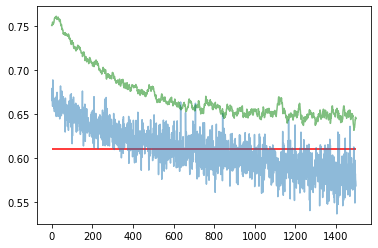

In [71]:
plt.plot(hists[-3], alpha = 0.5)
plt.hlines(np.mean(hists[-3]), 0, n_epochs, color = "r")
plt.plot(hists[-1], alpha = 0.5, color = "green")

0.6110970206754848 178


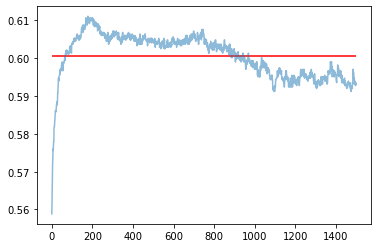

In [72]:
print(np.max(hists[-4]), np.argmax(hists[-4]))
plt.plot(hists[-4], alpha = 0.5)
plt.hlines(np.mean(hists[-4]), 0, n_epochs, color = "r")